In [114]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ggplot import *
import brewer2mpl
import dateutil
from random import shuffle

%matplotlib inline

In [115]:
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.metrics import make_scorer        
from sklearn.grid_search import ParameterGrid

# 1. Understand Data

In [116]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [117]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10886 entries, 0 to 10885
Data columns (total 12 columns):
datetime      10886 non-null object
season        10886 non-null int64
holiday       10886 non-null int64
workingday    10886 non-null int64
weather       10886 non-null int64
temp          10886 non-null float64
atemp         10886 non-null float64
humidity      10886 non-null int64
windspeed     10886 non-null float64
casual        10886 non-null int64
registered    10886 non-null int64
count         10886 non-null int64
dtypes: float64(3), int64(8), object(1)
memory usage: 1.1+ MB


##  1.1 Conclusion
1. We have **10 886** observations and **12** features.
2. We don't have missing value.
3. Most value is integer, few of them float and object (should be a date).

**Let's check more detail each features.**

In [118]:
train.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


## 1.2 Conlusion

1. **count** is target value and it changes between from **1** to **977**.
2. **holiday**, **workingday** is a binary variables (0 or 1).
3. **season**, **weather** - categorical variable (1,2,3 or 4).
4. **registered** and **casual** there's only in training set.
5. rest features is numerical variables.

**Let's try to visualise distribution each features.**

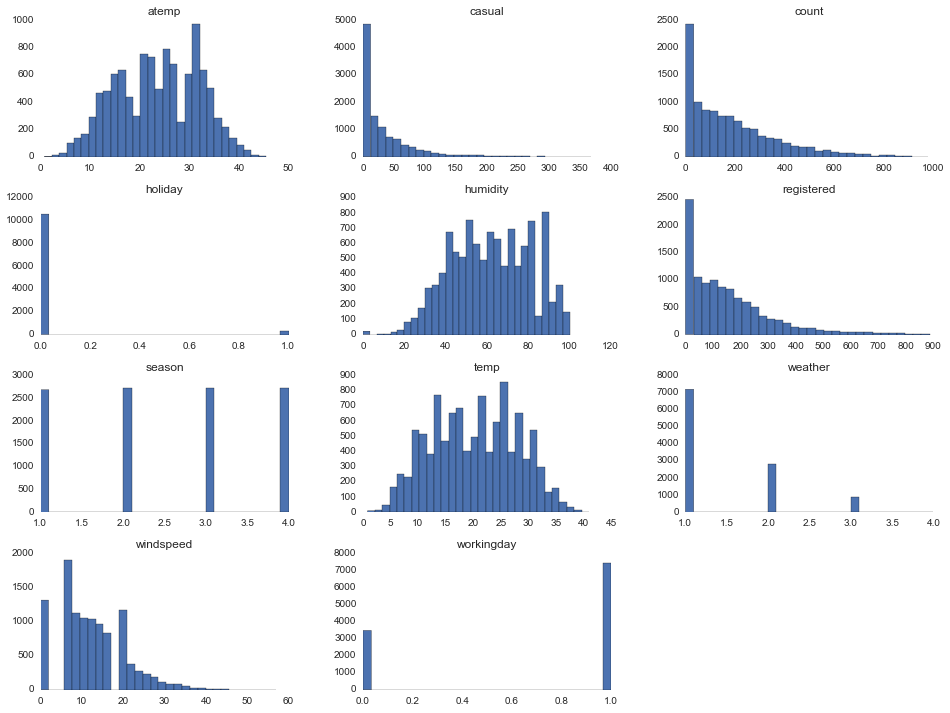

In [119]:
train.hist(figsize=(16,12),bins=30)
plt.show()

## 1.3 conclusion
1. **atemp** have some spikes on 10,20,30 (more rounded number).
2. **count** the most value is in the first bucket and have big tail on the second right. We can try transform using log (it can be helpful).
3. **weather** looks like corelated to count of rows.
4. ** season** all buckets look comparatively equal.
5. **windspeed** there're some missing buckets between 0 and 10, and 19. Maybe it's some problem with data (human error).

Let's try transform count using log.

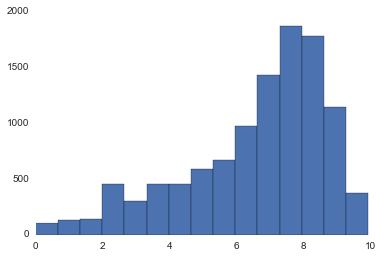

In [120]:
train['count_log'] = train['count'].map(lambda x: np.log2(x))
train.count_log.hist(bins=15)

# 2. Prepare Data
1. Correlation matrix
2. Importance features
3. Feature engineering
4. Feature selection

## 2.1 Correlation matrix

**Let's to see correlation matrix**

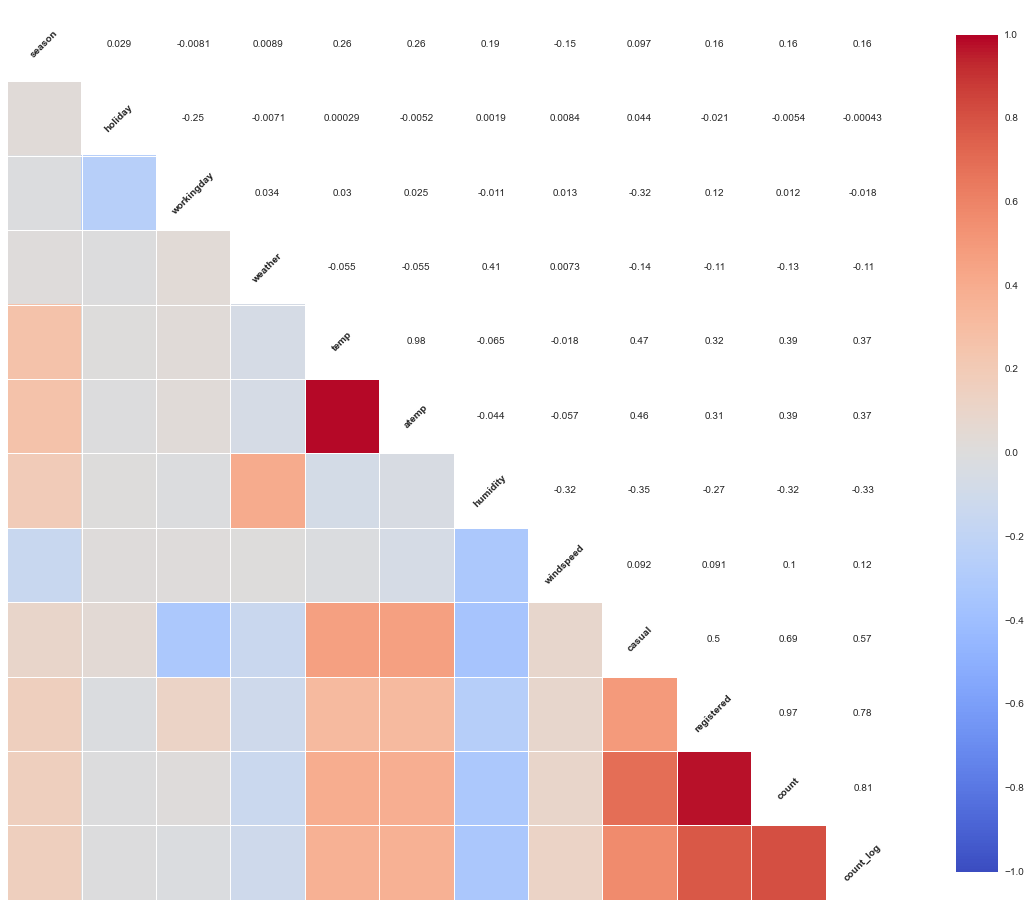

In [121]:
f, ax = plt.subplots(figsize=(20,20))
sns.corrplot(train, sig_stars=False, ax=ax)

1. **count** vs **registered**, **casual** (0.97, 0.69) correlated (it's not big surprise).
2. **count** vs **temp**, **atemp** also correlated, but less (0.39, 0.39).
3. **count** vs **humidity**, **weather** have inverse correlation (-0.32, -0.13).

## 2.2 Importances features

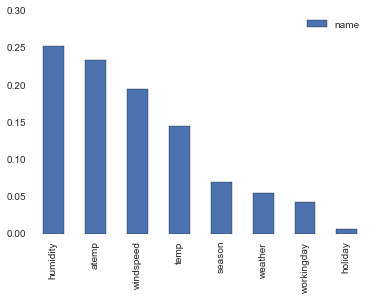

In [122]:
def select_features(data):
    return [feat for feat in data.columns if feat not in ['count_log', 'count', 'casual', 'registered', 'datetime']]

def get_X_y(data, cols=None):
    if not cols:
        cols = select_features(data)
        
    X = data[cols].values
    y = data['count'].values
    
    return X,y

def get_importance__features(data, model=RandomForestRegressor(), limit=20):
    X,y = get_X_y(data)
    cols = select_features(data)
    
    model.fit(X, y)
    feats = pd.DataFrame(model.feature_importances_, index=data[cols].columns)
    feats = feats.sort([0], ascending=False) [:limit]
    return feats.rename(columns={0:'name'})
    
def draw_importance_features(data, model=RandomForestRegressor(), limit=20):
    feats = get_importance__features(data, model, limit)
    feats.plot(kind='bar')


draw_importance_features(train)

## 2.3 Feature enginnering
Let's try figure out new feature based on exists. Feature **datetime** can be split into few part: **year**, **month**, **day**, **hour**, **minute**, **dayofweek**, **weekend**.

In [123]:
def temp_cat(temp):
    if temp < 15: return 1
    if temp < 25: return 2
    return 3

def cat_hour(hour):
    if 5 >= hour < 10:
        return 1#morning
    elif 10 >= hour < 17:
        return 2#day
    elif 17 >= hour < 23:
        return 3 #evening
    else:
        return 4 #night

def etl(df):
    df['datetime'] = pd.to_datetime( df['datetime'] )
    
    #time
    df['year'] = df['datetime'].map(lambda x: x.year)
    df['month'] = df['datetime'].map(lambda x: x.month)
    df['day'] = df['datetime'].map(lambda x: x.day)
    df['hour'] = df['datetime'].map(lambda x: x.hour)
    df['minute'] = df['datetime'].map(lambda x: x.minute)
    df['dayofweek'] = df['datetime'].map(lambda x: x.dayofweek)
    df['weekend'] = df['datetime'].map(lambda x: x.dayofweek in [5,6])
    df['time_of_day'] = df['hour'].map(cat_hour)
    
    #temp
    df['temp_cat'] = df['temp'].map(temp_cat)
    df['temp_hour'] = df.apply(lambda x: x['temp'] * x['hour'], axis=1)
    
    #season 
    df['season_weather'] = df.apply(lambda x: x['season'] * x['weather'], axis=1)
    df['season_temp'] = df.apply(lambda x: x['season'] * x['temp'], axis=1)
    df['season_atemp'] = df.apply(lambda x: x['season'] * x['atemp'], axis=1)
    df['season_hour'] = df.apply(lambda x: x['season'] * x['hour'], axis=1)
    
    #squared
    df['temp2'] = df['temp'].map(lambda x: x**2)
    df['humidity2'] = df['humidity'].map(lambda x: x**2)
    df['weather2'] = df['weather'].map(lambda x: x**2)
    

etl(train)
etl(test)

Let's see how changed importances features after adding new one.

None


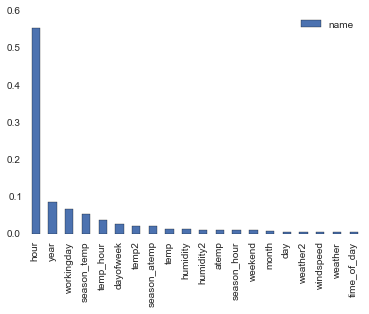

In [124]:
print draw_importance_features(train)

1. **hour** - looks like very importance feature.
2. new generated features: **seasson_attemp**, **temp2**, **dayofwork**, **humidity2** - there're on top 10.

Let's check distrubution count of rent by hour in working day and non working day.

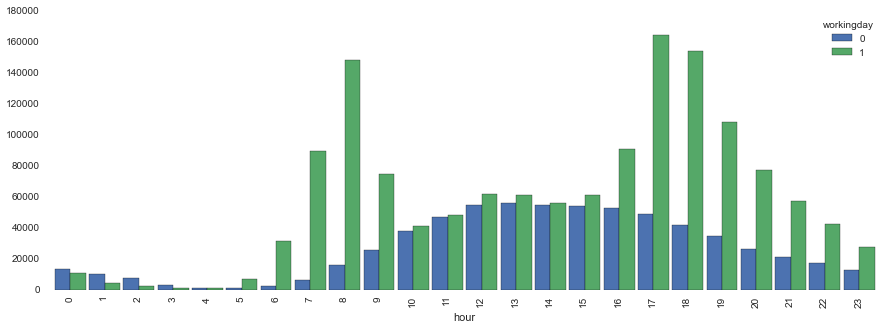

In [125]:
by_hour = train.groupby(['hour', 'workingday'])['count'].agg('sum').unstack()
by_hour.plot(kind='bar', figsize=(15,5), width=0.9)

1. On working day we have few spikes at 7,8,9 (going to work) and 17,18,19 (return to home).
2. On non working day looks more smoothing (without any spikes).
3. In the middle day (from 10 to 15) count of rent looks simmilar.
4. On working day count of rent greater than non-working day.
5. A little greater count of rent at the night in non-working day.

**Let's see how change range count of rent by hour.**

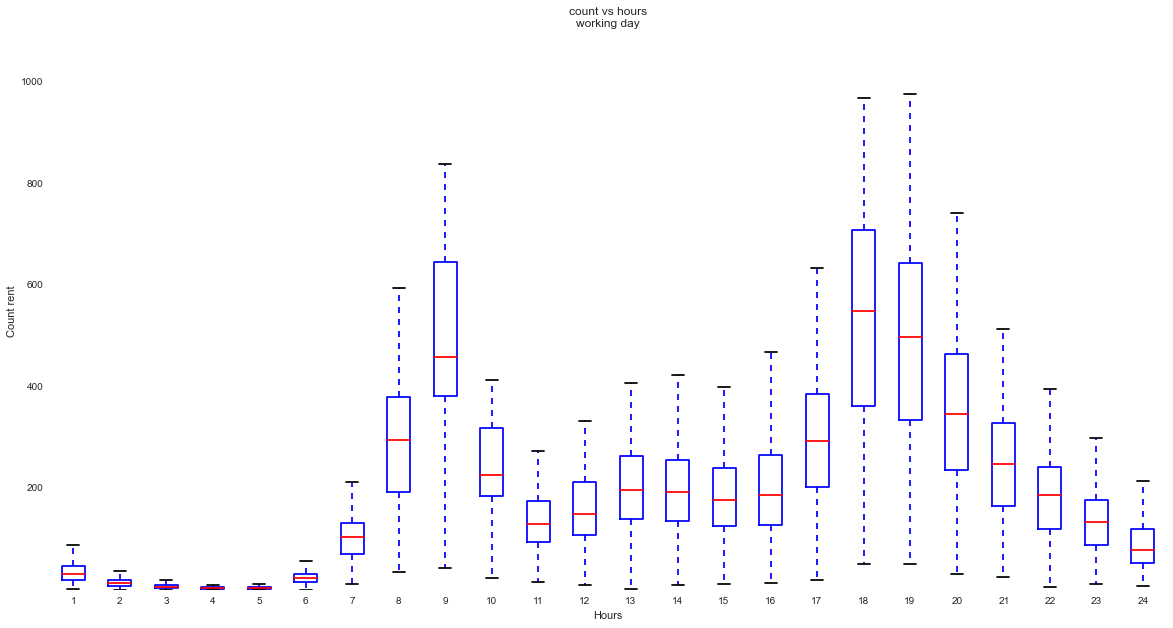

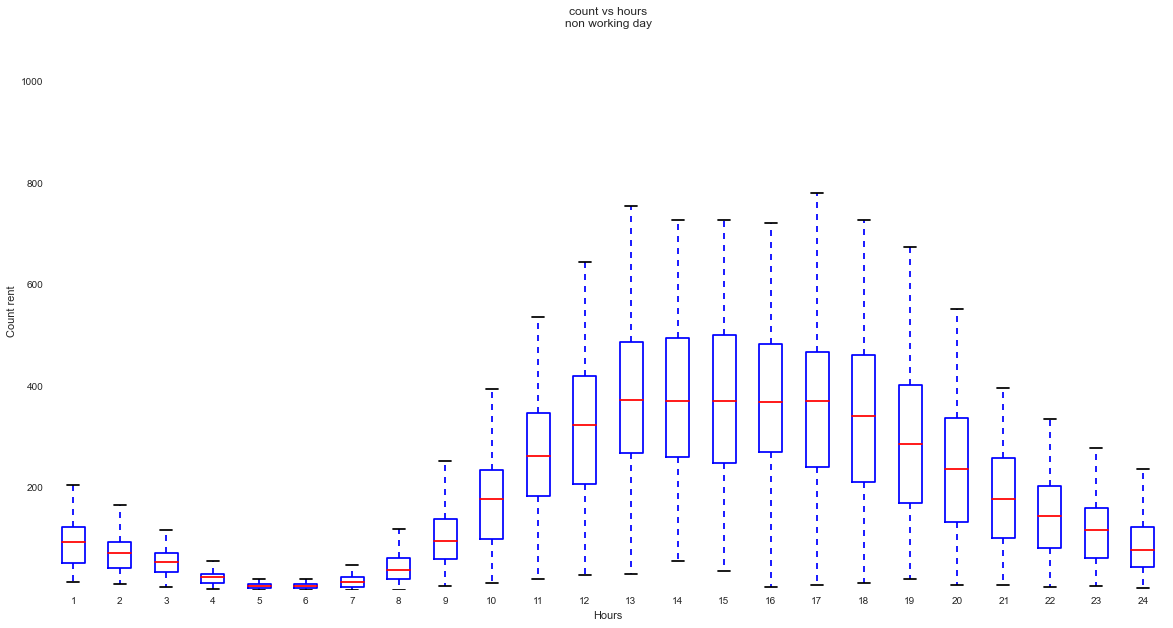

In [126]:
def plot_hours(data, message = ''):
    hours = {}
    for hour in range(24):
        hours[hour] = data[ data.hour == hour ]['count'].values

    plt.figure(figsize=(20,10))
    plt.ylabel("Count rent")
    plt.xlabel("Hours")
    plt.title("count vs hours\n" + message)
    plt.boxplot( [hours[hour] for hour in range(24)] )
    
    axis = plt.gca()
    axis.set_ylim([1, 1100])
    

plot_hours( train[train.workingday == 1], 'working day')
plot_hours( train[train.workingday == 0], 'non working day')

1. The biggest variance for working day is at 8,9 and 18,19,20.
2. The biggest variance for non-working day is from 12 to 20.

Why there's to big range at 9am on working day?

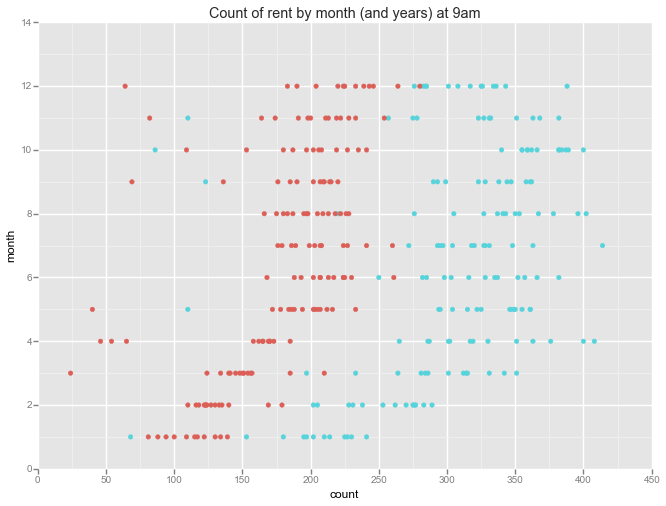

<ggplot: (287746573)>

In [127]:
t9 = train[ (train.hour == 9) & (train.workingday == 1) ].reset_index()
ggplot(aes(x='count', y='month', color='year'), t9) + geom_point()\
    + ggtitle('Count of rent by month (and years) at 9am') 

1. There's some wave pattern (from Jan to Aug increased, then decreased).
2. More bikes rent in 2012 (blue points) rather than 2011 (red points).
3. Ther're some outliers (e.g. Mar, Apr, May 2011 - red points).

Let's plot by years.

111.0 199.0
188.0 319.0


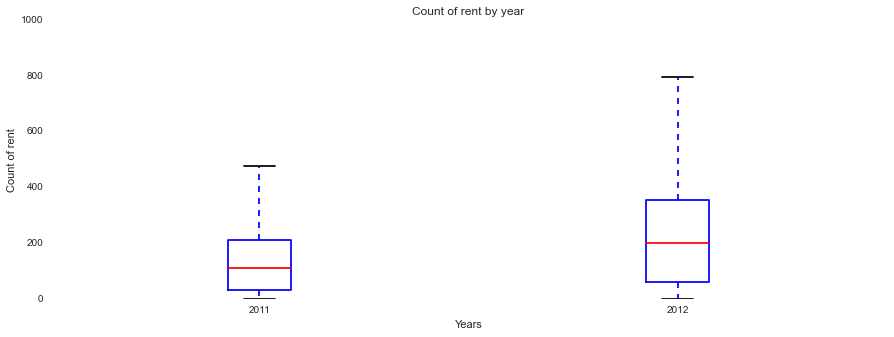

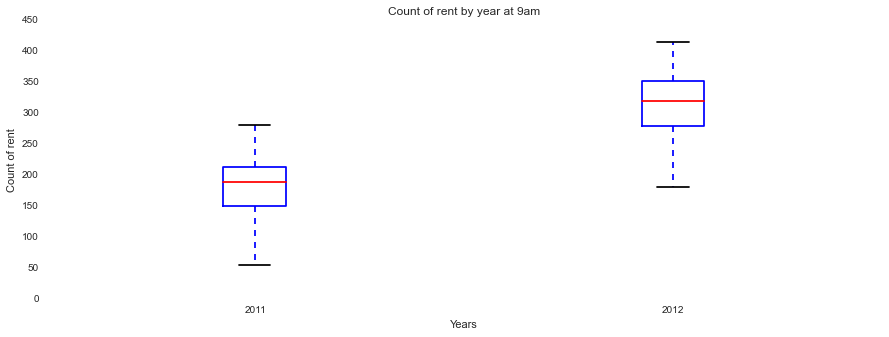

In [128]:
def plot_by_years(data, title):
    values = [ data[data.year == 2011]['count'].values, data[data.year == 2012]['count'].values]
    print np.median(values[0]), np.median(values[1])
    plt.figure(figsize=(15,5))
    plt.boxplot(values)
    plt.xlabel("Years")
    plt.ylabel("Count of rent")
    plt.title(title)
    _ = plt.xticks([1, 2], [2011, 2012])
    

plot_by_years(train, 'Count of rent by year')
plot_by_years(t9, 'Count of rent by year at 9am')

1. In general count of rent in 2012 increased, but median looks simillar (111 and 199).
2. At 9am median for **2011** is equal to **188**, but for **2012** is **319**. It looks like count of rent increased twice in 2012.


## 2.4 Feature selection

In [194]:
def get_cols():
    feats = get_importance__features(train, limit=50)
    return [feat for feat in feats[ feats.name > 0 ].index if feat  not in ['is_test']]

# 3. Modeling and Evaluation
1. Preapre quality function
2. Prepare training set and validate set
3. Single variable model (base line)
4. Using more advanced models
5. Tuning hyperparameters
6. Detect problem in actual models

## 3.1 Quality function

$$ \sqrt{\frac{1}{n} \sum_{i=1}^n (\log(p_i + 1) - \log(a_i+1))^2 }$$

where  
**n** is the number of hours in the test set  
**pi** is your predicted count  
**ai** is the actual count  
**log(x)** is the natural logarithm  

In [130]:
def rmsle(y_true, y_pred):
    diff = np.log(y_pred + 1) - np.log(y_true + 1)
    mean_error = np.square(diff).mean()
    return np.sqrt(mean_error)

scorer = make_scorer(rmsle, greater_is_better=False)

## 3.2 Train and test sets
Let's check distribution by days in train set.

In [131]:
train.day.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19])

So we have from **1 to 19**. We can try split this from **1-14** (2 weeks) like train set and **15-19** like a test set.

Note: *this way have some problem, but looks good enough for starting*

In [132]:
def train_test_split(data, last_training_day=0.3):
    days = train.day.unique()
    shuffle(days)
    test_days = days[: len(days) * 0.3]
    
    data['is_test'] = data.day.isin(test_days)
    df_train = data[data.is_test == False] 
    df_test  = data[data.is_test == True]
    
    return df_train, df_test

## 3.3 Single variable model

In [133]:
df_train, df_test = train_test_split(train)

mean_model = df_train.groupby('hour').mean()['count'].reset_index().to_dict()['count']
median_model = df_train.groupby('hour').median()['count'].reset_index().to_dict()['count']

y_true   = df_test['count'].values
y_mean   = df_test['hour'].map(lambda hour:  int(mean_model[hour]) ).values
y_median = df_test['hour'].map(lambda hour:  int(median_model[hour]) ).values

print 'mean', rmsle(y_true, y_mean)
print 'median', rmsle(y_true, y_median)

mean 0.79705817138
median 0.767721019165


**Median** looks a little better. Let's try to build more advanced model.

## 3.4 More advanced models

In [136]:
cols = get_cols()
model = RandomForestRegressor()
df_train, df_test = train_test_split(train)

def get_y_pred(model, cols):
    X_train = df_train[ cols ].values
    y_train = df_train[ 'count' ].values
    X_test  = df_test[ cols ].values

    model.fit(X_train, y_train)
    return model.predict(X_test)

def predict(model, cols):
    y_true  = df_test['count'].values
    y_pred = get_y_pred(model, cols)
    return rmsle(y_true, y_pred)


def models():
    yield ExtraTreesRegressor()
    yield RandomForestRegressor()
    yield AdaBoostRegressor()
    yield BaggingRegressor()
    yield DecisionTreeRegressor()

results = {}
for model in models():
    results[ predict(model, cols) ] = model

In [137]:
for key in sorted(results.keys()):
    print key, results[key]

0.372899552074 BaggingRegressor(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=1.0, max_samples=1.0,
         n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
         verbose=0)
0.375047901919 ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
          verbose=0, warm_start=False)
0.385379868995 RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)
0.450158179177 DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_

### The best results
1. **RandomForestRegressor**
2. **BaggingRegressor**
3. **ExtraTreesRegressor**

Improving twice result comparing to single model variable (~0.37 compare to ~0.77).

## 3.5 Tuning model
Let's try tuning two models: 
- `RandomForestRegressor` 
- `BaggingRegressor` 
- `ExtraTreesRegressor`

In [75]:
rf_params = {
    'n_estimators': [100, 200], 
    'min_samples_split': [5, 15, 20], 
    'n_jobs': [-1],
    'min_samples_leaf': [1, 2]
}

bagging_params = {
    'n_estimators': [100, 150, 170],
    'n_jobs': [-1],
}

extratree_params = {
    'n_estimators': [50, 100, 150],
    'min_samples_leaf': [1, 2],
    'min_samples_split': [2, 3, 7],
    'n_jobs': [-1],
}

models = [
    (rf_params, RandomForestRegressor()), 
    (bagging_params, BaggingRegressor()),
    (extratree_params, ExtraTreesRegressor())
]

results = {}
for params_model, model in models:
    key_model = str(model)
    results[key_model] = []
    
    for params in ParameterGrid(params_model):
        model.set_params(**params)
        results[key_model].append( (predict(model, cols), params) )
        
for key in results.keys():
    print key, sorted(results[key], key=lambda x: x[0])[0]

ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
          verbose=0, warm_start=False) (0.3458557191839145, {'min_samples_split': 3, 'n_estimators': 150, 'n_jobs': -1, 'min_samples_leaf': 1})
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False) (0.3520417798618547, {'min_samples_split': 5, 'n_estimators': 200, 'n_jobs': -1, 'min_samples_leaf': 2})
BaggingRegressor(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=1.0, max_samples=1.0,
         n_estimators=10, n_job

1. **ExtraTreesRegressor** with params `{'min_samples_split': 3, 'n_estimators': 150, 'min_samples_leaf': 1}`
2. **RandomForestRegressor** with params `{'min_samples_split': 5, 'n_estimators': 200, 'min_samples_leaf': 2}`
3. **BaggingRegressor** with params `{'n_estimators': 170}`

### Use count_log for prediction


In [211]:
def log_predict(df_train, df_test, is_traininig=True):
    cols = get_cols()

    X_train = df_train[cols].values
    y_train = df_train['count_log'].values
    X_test  = df_test[cols].values
    if is_traininig:
        y_true  = df_test['count'].values

    model = ExtraTreesRegressor(**{'min_samples_split': 3, 'n_estimators': 150, 'min_weight_fraction_leaf': 0.1, 'min_samples_leaf': 2})
    model.fit(X_train, y_train)
    y_log_pred = model.predict(X_test)
    y_pred = np.exp2( y_log_pred ).astype(int)
    
    if is_traininig:
        return rmsle(y_true, y_pred)
    else:
        return y_pred
    
print log_predict(df_train, df_test)

0.339510634232


## Predict value on test set

In [212]:
test['count'] = log_predict(train, test, is_traininig=False)
test[ ['datetime', 'count'] ].to_csv('result1.csv', index=False)

### Kaggle score for this solution is **0.41740**.